In [1]:
import numpy as np
from scipy.spatial.transform import Rotation 
from scipy.optimize import minimize

In [2]:
class Horn:
    def __init__(self,phi=-30):
        self.set_phi(phi)
        
    def set_phi(self,phi_deg):
        phi_rad = phi_deg/180.*np.pi
        dh = 69.0
        dv = 69.1
        p1 = [-dh/2,0,0]
        p2 = [+dh/2,0,0]
        p3 = [+dh/2, dv*np.sin(phi_rad),-dv*np.cos(phi_rad)]
        p4 = [-dh/2, dv*np.sin(phi_rad),-dv*np.cos(phi_rad)]
        self.points = [np.array(p) for p in [p1,p2,p3,p4]]
    
class Dish:
    def __init__(self, x0, y0, z0, alpha, beta, f, dphi, r0, r1):
        self.set_params(x0, y0, z0, alpha, beta, f, dphi, r0, r1)
    
    def set_params(self,x0,y0,z0,alpha,beta, f, dphi, r0, r1):
        ofs = np.array([x0,y0,z0])        
        ## petal from center, upring
        points_pet = [ (4,4), (5,3), (5,2), (5,1), (0,1), (-5,1), (-5,2), (-5,3), (-4,4)]
        dphi_rad = dphi/180*np.pi
        def get_point ( petal, upright, f):
            r = r0+(upright-1)*r1
            x = r*np.sin(dphi_rad*petal)
            y = r*np.cos(dphi_rad*petal)
            z = r*r/(4*np.abs(f))
            #print (r,x,y,z,dphi_rad, petal, upright)
            #stop()
            return np.array([x,y,z])
        
        points_xyz = [get_point(petal, upright,f) for petal,upright in points_pet]
        #print (points_xyz)
        #stop()
        ## now rotate them by alpha,beta and offset
        R = Rotation.from_euler('zy',[alpha,beta],degrees=True).as_matrix()   
        points_xyz = [np.dot(R,p)+ofs for p in points_xyz]
        self.points_xyz = points_xyz
    
def predict_measurements(vec):
    H = Horn(vec[0])
    pH = H.points
    D = Dish(*vec[1:])    
    pD = D.points_xyz
    #print (pD)
    def dist(p1,p2):
        return np.sqrt(np.sum((p1-p2)**2))
    pred = np.array([[dist(p1,p2) for p1 in pH] for p2 in pD])
    return pred

        

In [3]:
measurements = np.array([
    [376.6, 337.0, 353.2, 390.8],
    [331.3, 291.8, 284.1, 324.1],
    [296.7, 269.2, 240.1, 269.5],
    [282.3, 271.1, 222.5, 235.6],    
    [272.5, 272.7, 228.3, 227.9],
    [270.0, 282.0, 236.5, 221.7],
    [266.7, 293.8, 269.4, 238.3],
    [288.3, 327.1, 323.1, 283.3],
    [333.7, 372.1, 389.4, 353.0]
])



In [4]:
# phi, x0,y0,z0,alpha,beta,f,dphi
start = np.array([-40, 0,-60,-270,0,0,290.,8., 70.,100.])
sigma = 0.3 ## sigma err in cm
predict_measurements(start)

array([[375.05267932, 337.0561298 , 353.32073206, 389.73480386],
       [328.26636847, 289.49705065, 282.30470812, 321.94132162],
       [292.69453502, 265.68833905, 235.91740086, 265.96393995],
       [277.48324218, 266.05943205, 216.46932237, 230.36556999],
       [268.19220507, 268.19220507, 222.38079332, 222.38079332],
       [266.05943205, 277.48324218, 230.36556999, 216.46932237],
       [265.68833905, 292.69453502, 265.96393995, 235.91740086],
       [289.49705065, 328.26636847, 321.94132162, 282.30470812],
       [337.0561298 , 375.05267932, 389.73480386, 353.32073206]])

In [5]:

def chi2 (vec):
    pred = predict_measurements(vec)
    chi2 = ((pred-measurements)**2/sigma**2).sum()
    return chi2




In [6]:
fit = minimize(chi2,start,tol=1e-2)
fit.fun

32.48924940317231

In [7]:
predict_measurements(fit.x)

array([[376.36740329, 336.64920111, 353.15657647, 391.20238389],
       [331.12361833, 291.62183783, 284.10900869, 324.52655228],
       [296.48003657, 269.6473988 , 239.96970648, 269.77055516],
       [282.23342035, 271.70004724, 222.90370329, 235.62862481],
       [272.10821628, 272.77118813, 228.11492211, 227.32174991],
       [269.86660286, 281.93957419, 236.10919936, 221.55273383],
       [266.79405748, 294.26745065, 269.12874985, 238.7802768 ],
       [288.14559669, 327.32478389, 323.02644421, 283.25333962],
       [333.95348902, 371.95070379, 389.18640798, 353.0490999 ]])

Text(0, 0.5, 'residuals [cm]')

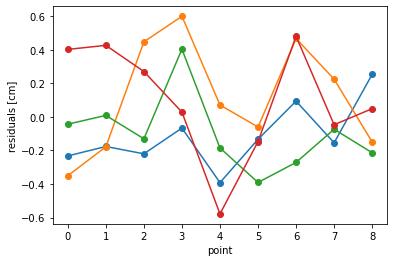

In [8]:
plt.plot(predict_measurements(fit.x)-measurements,'-o')
plt.xlabel('point')
plt.ylabel('residuals [cm]')

In [9]:
vals = fit.x
errs=np.sqrt((fit.hess_inv.diagonal())*2)
names = 'phi x0 y0 z0 alpha beta f theta r0 r1'.split()
for n,v,e in zip(names,vals, errs):
    print (f"{n} = {v:.2f} +/- {e:.2f}")

phi = -42.71 +/- 0.44
x0 = -4.28 +/- 0.51
y0 = -66.40 +/- 1.91
z0 = -274.38 +/- 0.20
alpha = -1.30 +/- 0.16
beta = 1.25 +/- 0.11
f = 288.44 +/- 5.73
theta = 8.13 +/- 0.05
r0 = 69.57 +/- 1.17
r1 = 100.81 +/- 0.28
